In [1]:
using Luna
using LaTeXStrings
using DelimitedFiles
using DSP

using PyPlot
pygui(true)

true

In [2]:
file_exp = joinpath("output_sorted", "Spectrum_after_MPC_50kHz_in_1.5barKr_last_configuration_15 roundtrips.txt")

#spectrum
data = readdlm(file_exp, '\t', skipstart=14)
λ_exp = data[:,1]   
Iλ_exp = data[:,2]


2048-element Vector{Float64}:
 52.0
 49.0
 57.0
 49.0
 48.0
 48.0
 57.0
 55.0
 59.0
 59.0
  ⋮
 75.0
 69.0
 61.0
 70.0
 65.0
 67.0
 62.0
 66.0
 66.0

In [3]:
main_dir = joinpath("output_sorted", "different energies")

"output_sorted\\different energies"

In [4]:
## using n2 of Esmerando
dir_path = joinpath(main_dir, "..", "2025-03-17_14-10-39")

#spectrum
file = joinpath(dir_path, "spectrum.txt")
data = readdlm(file, '\t', skipstart=1)
λ_esm = data[:,1]   
Iλ_esm = data[:,2]
ϕλ_esm = data[:,3]

# pulse temporal
file = joinpath(dir_path, "pulse.txt")
data = readdlm(file, '\t', skipstart=1) 
t_esm = data[:,1].*1e15 
It_esm = data[:,2] 
ϕt_esm = data[:,3]

8192-element Vector{Float64}:
   2.36694956443765
   2.42130371797081
   2.47223609547
   2.57071276618099
   2.65751373701365
   2.77222806547602
   2.85736789884796
   2.94647658764705
   2.99787057310853
   3.04654620355698
   ⋮
 116.008593710614
 115.959365480443
 115.904060345449
 115.787722916108
 115.698988409539
 115.585526357039
 115.527699570739
 115.466140092301
 115.465548148423

In [5]:
open(joinpath(main_dir, "run_2025_04_23__12_31_16", "params.txt"), "r") do file
    # Iterate over each line of the file
    for line in eachline(file)
        println(line)
        if occursin(r"^\s*τ\s*=", line)
            println("found")
        end
    end
end

# pulse parameters
λ0         = 1.03e-6
τ          = 1.5e-13
found
E_pulse    = 0.00015
w0         = 0.00011547828514537358
wm         = 0.0005554198741358596
M2         = 1.0
σ          = 1

# MPC parameters
L          = 0.38270909152852023
R          = 0.2
L/R        = 1.913545457642601
k          = 13
Npass      = 30
mtype      = spherical
propz      = -0.19135454576426011
z_vals     = [0.0, 0.19135454576426011, 0.38270909152852023]

gas        = Kr
pres       = 1.5
n0         = 1.0005843204424483
n2         = 3.4199449874306914e-23
ion        = true
ion_model  = PPT

# MPC mirrors
windowwidth1 = 2.0e-8
λ_min1     = 8.200000000000001e-7
λ_max1     = 1.28e-6
delay1     = 2.0e-13
windowwidth2 = 2.0e-8
λ_min2     = 8.200000000000001e-7
λ_max2     = 1.28e-6
delay2     = nothing

# simulation grid parameters
λlims      = (6.0e-7, 1.5e-6)
trange request = 7.499999999999999e-13
trange used    = 1.3656114057412343e-12
Nω         = 1025
Nt         = 2048
Nz         = 201

# Hankel transforma

In [6]:
function extract_param(filepath::String, param::String)
    pattern = r"^" * param * r"\s*=\s*([^\s#]+)"
    for line in eachline(filepath)
        m = match(pattern, line)
        if m !== nothing
            val_str = m.captures[1]
            try
                # Try to parse as a number
                return parse(Float64, val_str)
            catch
                # If parsing fails, return the string as is (could be "nothing", "true", etc.)
                return val_str
            end
        end
    end
    error("Parameter '$param' not found in file.")
end

# Usage examples:
tau_value = extract_param(joinpath(main_dir, "run_2025_04_23__12_31_16", "params.txt"), "τ")
println("τ = ", tau_value)
println(typeof(tau_value))

gas_type = extract_param(joinpath(main_dir, "run_2025_04_23__12_31_16", "params.txt"), "gas")
println("gas = ", gas_type)
println(typeof(gas_type))

ion = extract_param(joinpath(main_dir, "run_2025_04_23__12_31_16", "params.txt"), "ion")
println("ion = ", ion)
println(typeof(gas_type))

energy = extract_param(joinpath(main_dir, "run_2025_04_23__12_31_16", "params.txt"), "E_pulse")
println("E_pulse = ", energy)
println(typeof(energy))

τ = 1.5e-13
Float64
gas = Kr
SubString{String}
ion = true
SubString{String}
E_pulse = 0.00015
Float64


## Energy scan without GDD compensation

In [7]:
dirs = readdir(main_dir)

# Initialize dictionaries to hold each column's data
t_data = Dict{Float64, Vector}()
It_data = Dict{Float64, Vector}()

λ_data = Dict{Float64, Vector}()
Iλ_data = Dict{Float64, Vector}()
ϕω_data = Dict{Float64, Vector}()

# Iterate over each entry in the folder
for dir in dirs
    # Construct the full path of the entry
    full_path = joinpath(main_dir, dir)

    # pulse temporal
    file = joinpath(full_path, "time_domain_output.txt")
    data = readdlm(file, '\t', skipstart=1) 

    E_pulse = extract_param(joinpath(full_path, "params.txt"), "E_pulse")
    tau = extract_param(joinpath(full_path, "params.txt"), "τ")
    println(tau)
    # println(E_pulse)
    # println(typeof(E_pulse))
    t_data[E_pulse] = data[:,1]
    It_data[E_pulse] = data[:,2]

    #spectrum
    file = joinpath(full_path, "output_spectrum.txt")
    data = readdlm(file, '\t', skipstart=1)

    λ_data[E_pulse] = data[:,1]   
    Iλ_data[E_pulse] = data[:,2]
    ϕω_data[E_pulse] = data[:,3]
end

1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13
1.5e-13


In [8]:
println(sort(collect(keys(t_data))))
println(collect(keys(t_data)))
println(keys(t_data))

[5.0e-5, 0.0001, 0.00015, 0.000152, 0.000154, 0.000156, 0.000158, 0.00016, 0.00017, 0.00018, 0.00019, 0.0002, 0.00021, 0.00022, 0.00023, 0.00024, 0.00025]
[0.00023, 0.00021, 0.00016, 0.00017, 5.0e-5, 0.000154, 0.000158, 0.00019, 0.00018, 0.0001, 0.0002, 0.000152, 0.000156, 0.00015, 0.00024, 0.00025, 0.00022]
[0.00023, 0.00021, 0.00016, 0.00017, 5.0e-5, 0.000154, 0.000158, 0.00019, 0.00018, 0.0001, 0.0002, 0.000152, 0.000156, 0.00015, 0.00024, 0.00025, 0.00022]


sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


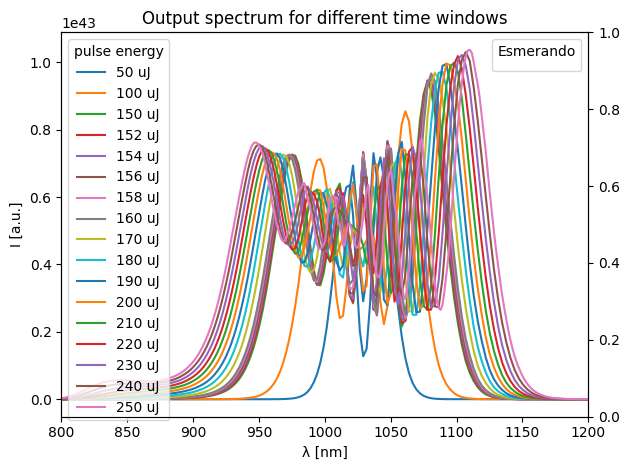

In [9]:
energies = sort(collect(keys(λ_data)))

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    #if energy >= 200.0e-6
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
    #end
end
ax2 = ax1.twinx()
#ax2.plot(λ_esm, Iλ_esm, label="Esm 250 uJ", color="black")

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="Esmerando", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

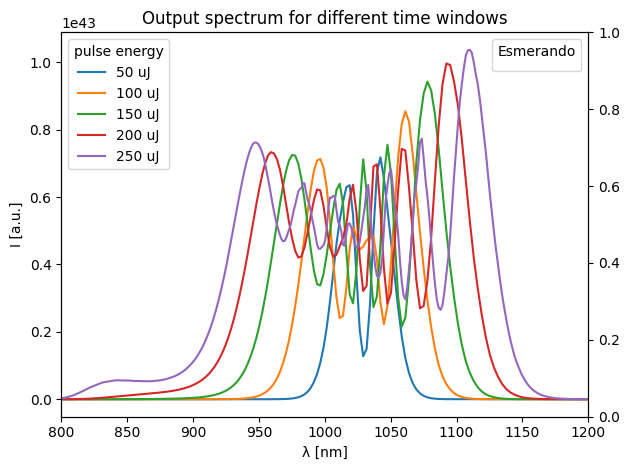

In [10]:
energies = [5.0e-5, 0.0001, 0.00015, 0.0002, 0.00025]

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    #if energy >= 200.0e-6
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
    #end
end
ax2 = ax1.twinx()
# ax2.plot(λ_esm, Iλ_esm, label="Esm 250 uJ", color="black")

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="Esmerando", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

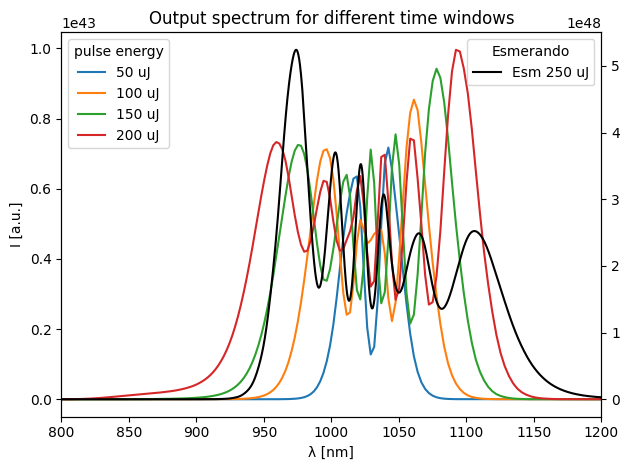

In [11]:
energies = [ 0.00005, 0.0001, 0.00015, 0.0002]

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    #if energy >= 200.0e-6
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
    #end
end
ax2 = ax1.twinx()
ax2.plot(λ_esm, Iλ_esm, label="Esm 250 uJ", color="black")

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="Esmerando", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

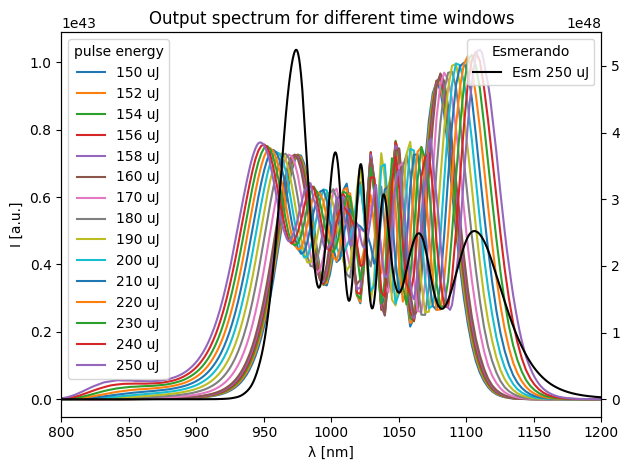

In [12]:
energies = sort(collect(keys(λ_data)))

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    if energy >= 150.0e-6
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
    end
end
ax2 = ax1.twinx()
ax2.plot(λ_esm, Iλ_esm, label="Esm 250 uJ", color="black")

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="Esmerando", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

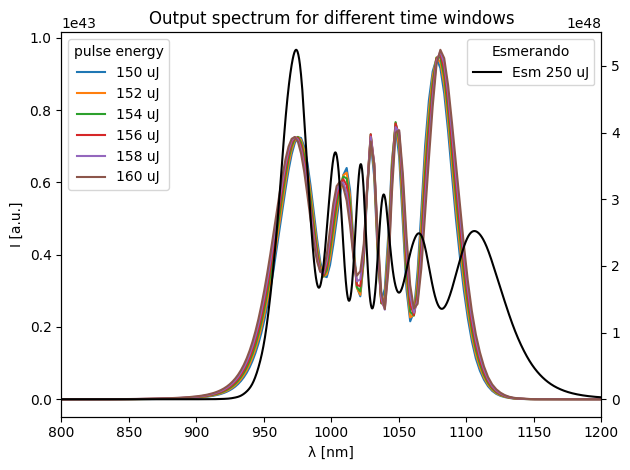

In [13]:
energies = sort(collect(keys(λ_data)))

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    if energy >= 150.0e-6 && energy <= 160.0e-6
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
    end
end
ax2 = ax1.twinx()
ax2.plot(λ_esm, Iλ_esm, label="Esm 250 uJ", color="black")

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="Esmerando", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

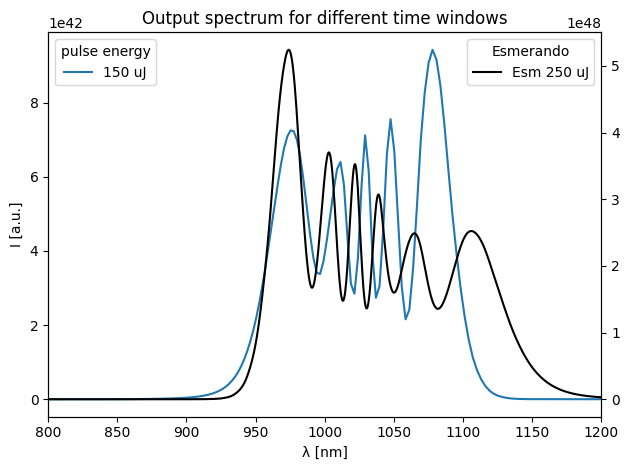

In [14]:
energies = [ 0.00015]#, 0.00016]#, 0.00017, 0.00018, 0.00019 ,0.0002]

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    if energy >= 150.0e-6
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
    end
end
ax2 = ax1.twinx()
ax2.plot(λ_esm, Iλ_esm, label="Esm 250 uJ", color="black")

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="Esmerando", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

## Different energies where GDD compensation was considered
-30 fs^2 GDD for every second pass

In [15]:
main_dir = joinpath("output_sorted", "different energies with GDD comp")

"output_sorted\\different energies with GDD comp"

In [16]:
dirs = readdir(main_dir)

# Initialize dictionaries to hold each column's data
t_data = Dict{Float64, Vector}()
It_data = Dict{Float64, Vector}()

λ_data = Dict{Float64, Vector}()
Iλ_data = Dict{Float64, Vector}()
ϕω_data = Dict{Float64, Vector}()

# Iterate over each entry in the folder
for dir in dirs
    # Construct the full path of the entry
    full_path = joinpath(main_dir, dir)

    # pulse temporal
    file = joinpath(full_path, "time_domain_output.txt")
    data = readdlm(file, '\t', skipstart=1) 

    E_pulse = extract_param(joinpath(full_path, "params.txt"), "E_pulse")
    tau = extract_param(joinpath(full_path, "params.txt"), "τ")
    println(tau)
    println(E_pulse)
    # println(typeof(E_pulse))
    t_data[E_pulse] = data[:,1]
    It_data[E_pulse] = data[:,2]

    #spectrum
    file = joinpath(full_path, "output_spectrum.txt")
    data = readdlm(file, '\t', skipstart=1)

    λ_data[E_pulse] = data[:,1]   
    Iλ_data[E_pulse] = data[:,2]
    ϕω_data[E_pulse] = data[:,3]
end

1.5e-13
5.0e-5
1.5e-13
0.0001
1.5e-13
0.00015
1.5e-13
0.0002
1.5e-13
0.00025


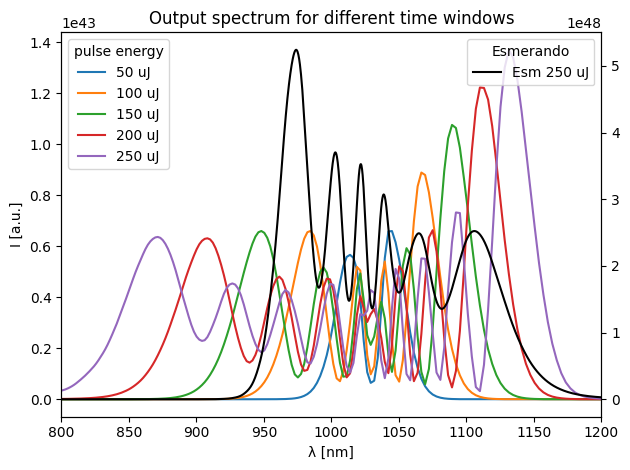

In [17]:
energies = sort(collect(keys(λ_data)))

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
end
ax2 = ax1.twinx()
ax2.plot(λ_esm, Iλ_esm, label="Esm 250 uJ", color="black")

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="Esmerando", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

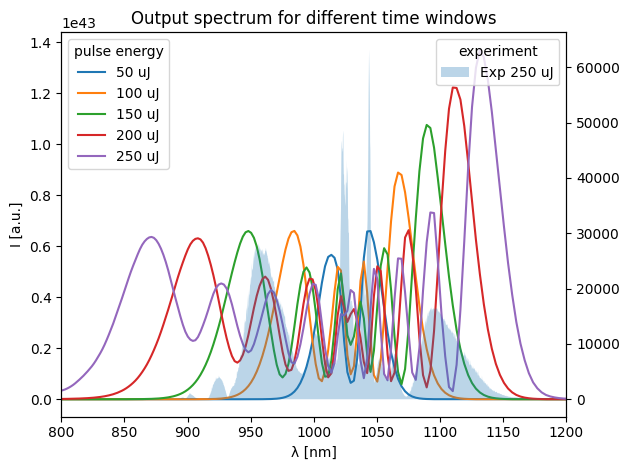

In [18]:
energies = sort(collect(keys(λ_data)))

fig, ax1 = plt.subplots()
ax1.set_title("Output spectrum for different time windows")
for energy in energies
    ax1.plot(λ_data[energy], Iλ_data[energy], label="$(ceil(Int, energy*1e6)) uJ")#, marker="o")
    # ax2.plot(λ_data[energy], ϕω_data[energy], label="$(ceil(Int, energy*1e6)) uJ")
end
ax2 = ax1.twinx()
#ax2.plot(λ_exp, Iλ_exp, label="Exp 250 uJ", color="black")
ax2.fill_between(λ_exp, Iλ_exp, label="Exp 250 uJ", alpha=0.3) 

ax1.set_xlim(800, 1200)
#ax1.set_ylim(0, 6e48)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [a.u.]")
#ax2.set_ylim(-260, -160)
# ax2.set_ylabel("phase [rad]")
ax1.legend(title="pulse energy", loc="upper left")
ax2.legend(title="experiment", loc="upper right")
#ax2.legend(loc="upper right")
plt.tight_layout()
# plt.show()
plt.gcf()

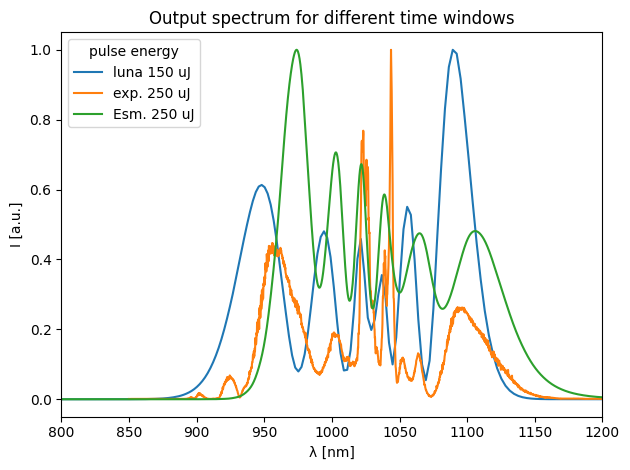

In [19]:


fig, ax1 = plt.subplots()
plt.title("Output spectrum for different time windows")
plt.plot(λ_data[0.00015], Maths.normbymax(Iλ_data[0.00015]), label="luna 150 uJ")#, marker="o")
plt.plot(λ_exp, Maths.normbymax(Iλ_exp), label="exp. 250 uJ")#, marker="o")
plt.plot(λ_esm, Maths.normbymax(Iλ_esm), label="Esm. 250 uJ")#, marker="o")

plt.xlim(800, 1200)
# plt.ylim(0, 6e48)
plt.xlabel("λ [nm]")
plt.ylabel("I [a.u.]")
plt.legend(title="pulse energy", loc="upper left")
plt.tight_layout()
# plt.show()
plt.gcf()